## This is the notebook used to process the final dataset containing primary tumors and matched metastasis

Dataset acquired with Vectra Polaris (multispectral - unmixed)

Images processed with branch of nf-core/mcmicro (kbestak/nf_mcmicro -r 'unstitch_restitch') based on the original MCMICRO pipeline(Schapiro et al. 2022).

Channels in order: DAPI, CD163, EPCAM, GFAP, CD8, cGAS, AF

Quantification files include mean intensities per cell per marker, and the number of assigned spot counts for the cGAS channel (spots detected with Spotiflow (Dominguez Mantes et al. 2024), spot_probability_threshold=0.6, spot_intensity_minimum=150). Segmentation performed with the Deepcell Mesmer 'whole-cell' model (Greenwald et al. 2022).

Original dataset subsetted by manual inspection to exclude samples with high DAPI background, unspecific staining, missing staining, significant folds, regions without focus and regions with bubbles.

Environment used is defined in /cell_type_calling/environment_hpc.yml

Data processing performed using Scimap (Nirmal et al., 2024) on the bwForCluster Helix.

In [1]:
# load libraries
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
from skimage.filters import threshold_otsu
import scimap as sm
from os.path import abspath
import pandas as pd
import os
import copy

Running SCIMAP  2.1.1


### Loading in data

In [2]:
# find paths of quantification files
quantification_dir = '/gpfs/bwfor/work/ws/hd_hl269-brainmets/uint16_data/dataset/combinequantifications'
quantification_path_list_raw = glob.glob(quantification_dir + '/*.csv')

In [3]:
# define sample ids from selected manual annotations
kept_sample_ids = ['Pat10_CA_lung_0',
 'Pat10_METS_brain_0',
 'Pat11_CA_lung_0',
 'Pat11_METS_brain_0',
 'Pat13_CA_lung_0',
 'Pat13_METS_brain_0',
 'Pat15_CA_lung_0',
 'Pat15_METS_brain_0',
 'Pat17_CA_lung_0',
 'Pat17_METS_brain_0',
 'Pat22_CA_lung_2',
 'Pat22_METS_brain_0',
 'Pat24_CA_lung_0',
 'Pat24_METS_brain_0',
 'Pat25_CA_lung_0',
 'Pat25_METS_brain_0',
 'Pat26_CA_lung_0',
 'Pat26_METS_brain_0',
 'Pat2_CA_lung_0',
 'Pat2_METS_brain_0',
 'Pat32_CA_lung_0',
 'Pat32_METS_brain_0',
 'Pat34_CA_lung_0',
 'Pat34_METS_brain_0',
 'Pat37_CA_lung_0',
 'Pat37_METS_liver_0',
 'Pat38_CA_lung_0',
 'Pat38_METS_chestwall_0',
 'Pat3_CA_lung_0',
 'Pat3_METS_brain_1',
 'Pat42_CA_lung_0',
 'Pat42_METS_spine_0',
 'Pat43_CA_lung_0',
 'Pat43_METS_ln_0',
 'Pat44_CA_lung_0',
 'Pat44_METS_pleura_0',
 'Pat49_CA_lung_0',
 'Pat49_METS_pleura_0',
 'Pat4_CA_lung_0',
 'Pat4_METS_spine_0',
 'Pat50_CA_lung_3',
 'Pat50_METS_vertebrae_0',
 'Pat51_CA_lung_2',
 'Pat51_METS_omperi_2',
 'Pat53_CA_lung_0',
 'Pat53_METS_pleura_0',
 'Pat54_CA_lung_0',
 'Pat54_METS_pleura_0',
 'Pat59_CA_lung_0',
 'Pat59_METS_brain_0',
 'Pat5_CA_lung_0',
 'Pat5_METS_spine_0',
 'Pat68_CA_lung_0',
 'Pat68_METS_adrenal_0',
 'Pat6_CA_lung_0',
 'Pat6_METS_brain_0',
 'Pat72_CA_lung_0',
 'Pat72_METS_pansto_0',
 'Pat77_CA_lung_0',
 'Pat77_METS_ln_2',
 'Pat7_CA_lung_0',
 'Pat7_METS_brain_0',
 'Pat80_CA_lung_0',
 'Pat80_METS_brain_0',
 'Pat85_CA_lung_0',
 'Pat85_METS_adrenal_0',
 'Pat87_CA_lung_2',
 'Pat87_METS_pleura_0',
 'Pat8_CA_lung_0',
 'Pat8_METS_brain_0']

In [4]:
# filter quantification files based on selected sample ids
quantification_path_list = [x for x in quantification_path_list_raw if any(y in x for y in kept_sample_ids)] # filt

In [5]:
# create anndata object from quantification files with Scimap
adata = sm.pp.mcmicro_to_scimap(quantification_path_list)

Loading combined_Pat50_METS_vertebrae_0.csv
Loading combined_Pat15_CA_lung_0.csv
Loading combined_Pat59_CA_lung_0.csv
Loading combined_Pat87_METS_pleura_0.csv
Loading combined_Pat38_CA_lung_0.csv
Loading combined_Pat37_CA_lung_0.csv
Loading combined_Pat24_CA_lung_0.csv
Loading combined_Pat87_CA_lung_2.csv
Loading combined_Pat49_CA_lung_0.csv
Loading combined_Pat11_METS_brain_0.csv
Loading combined_Pat51_CA_lung_2.csv
Loading combined_Pat3_CA_lung_0.csv
Loading combined_Pat2_CA_lung_0.csv
Loading combined_Pat72_CA_lung_0.csv
Loading combined_Pat50_CA_lung_3.csv
Loading combined_Pat8_METS_brain_0.csv
Loading combined_Pat51_METS_omperi_2.csv
Loading combined_Pat77_CA_lung_0.csv
Loading combined_Pat8_CA_lung_0.csv
Loading combined_Pat80_METS_brain_0.csv
Loading combined_Pat7_METS_brain_0.csv
Loading combined_Pat26_CA_lung_0.csv
Loading combined_Pat54_CA_lung_0.csv
Loading combined_Pat13_METS_brain_0.csv
Loading combined_Pat2_METS_brain_0.csv
Loading combined_Pat53_METS_pleura_0.csv
Loading

### Data preprocessing

In [6]:
# Extract sample metadata from imageid and sampleid
adata.obs['sampleid'] = adata.obs['imageid'].apply(lambda x: x.split("combined_")[1])
adata.obs['patientid'] = adata.obs['sampleid'].apply(lambda x: x.split("_")[0].split("Pat")[1])
adata.obs['tumor'] = adata.obs['sampleid'].apply(lambda x: x.split("_")[1])
adata.obs['tissue'] = adata.obs['sampleid'].apply(lambda x: x.split("_")[2])
adata.obs['index'] = adata.obs['sampleid'].apply(lambda x: x.split("_")[3])

# Filter out smallest and largest 1% of cells to exclude outliers
adata = adata[adata.obs['Area'] > adata.obs['Area'].quantile(0.01), :]
adata = adata[adata.obs['Area'] < adata.obs['Area'].quantile(0.99), :]

Per sample and channel of interest (channels 1-CD163, 2-EPCAM, 4-CD8), to counteract batch effect, the values are normalized to the 99th percentile value as all three of the markers are expected to be expressed in all samples. Since GFAP is not expected to be expressed in non-brain metastasis samples, this method would boost low intensity signal therefore for that channel, one value was chosen for the whole dataset. In addition, measured cGAS mean intensities are not used, but were only used for spot detection so they can also be excluded here.

In [7]:
unique_sample_ids = adata.obs['sampleid'].unique()
sample_indices = adata.obs['sampleid'] == unique_sample_ids[0]

adata_copy = copy.copy(adata)

channels = [1, 2, 4] # Channels CD163, EPCAM, CD8

unique_sample_ids = adata_copy.obs['sampleid'].unique()

for sample_id in unique_sample_ids:
    sample_indices = adata_copy.obs['sampleid'] == sample_id # Get the indices for the current sample ID
    sample_data = np.array(adata_copy.X[sample_indices, :]) # Extract the submatrix for the current sample
    
    # Iterate over each specified channel/column
    for i in channels:
        # Calculate the 99th percentile value for the channel
        data_column = sample_data[:, i].toarray().flatten() if hasattr(sample_data[:, i], "toarray") else sample_data[:, i].flatten()
        percentile_99 = np.percentile(data_column, 99)
        
        # Rescale the channel values by the 99th percentile value
        if percentile_99 > 0:
            sample_data[:, i] = sample_data[:, i] / percentile_99
    
    # Update the values in the original matrix
    adata_copy.X[sample_indices, :] = sample_data

adata = adata_copy

/scratch/hd_hl269/job_4072868_m08n17/ipykernel_3006225/3701446162.py:25: ImplicitModificationWarning:

Trying to modify attribute `.X` of view, initializing view as actual.



### Threshold selection

For CD163 and CD8 the threshold was decided through visual inspection of multiple images in Napari using Scimap's gate_finder function.

For the EPCAM channel, the Otsu threshold found at 0.39 was used and validated with visual inspection.

For the GFAP channel, a threshold of 4.8 (on log1p values) was also determined through inspection of multiple images using Scimap's gate_finder function.

In [8]:
CD163_threshold = 0.8
EPCAM_threshold = 0.39
CD8_threshold = 0.8
GFAP_threshold = 4.8

def plot_distribution(adata, channel, threshold, xlim_max=1.5, show_above=0):
    channel_array = np.array(adata.X[:,adata.uns["all_markers"].index(channel)])
    channel_array = channel_array[channel_array > show_above] # only plot values above 0
    
    plt.hist(channel_array, bins=100)
    plt.xlabel(f'{channel} Log1p intensity')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {channel} values')
    plt.axvline(threshold, color='r')
    plt.text(threshold + 0.05, 1000, str(round(threshold, 2)))
    plt.xlim(show_above, xlim_max)
    plt.show()
    plt.savefig(f'/gpfs/bwfor/work/ws/hd_hl269-brainmets/uint16_data/dataset/plots/{channel}_histogram.png')

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

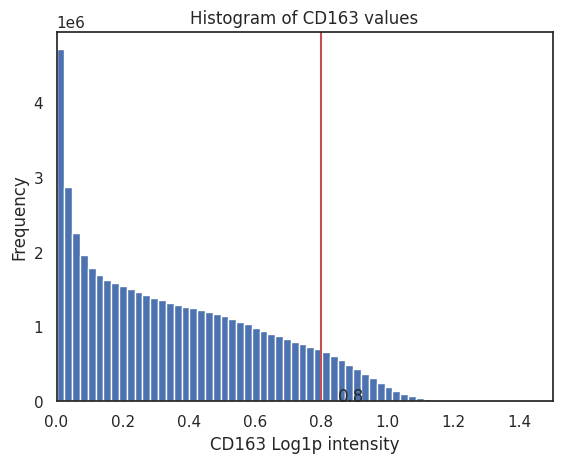

<Figure size 640x480 with 0 Axes>

In [9]:
plot_distribution(adata, 'CD163', CD163_threshold)

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

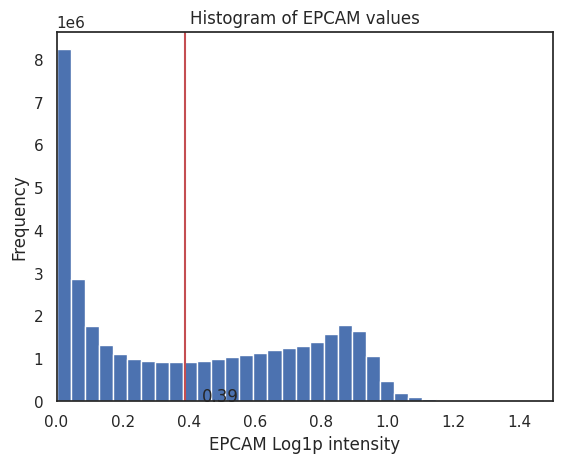

<Figure size 640x480 with 0 Axes>

In [10]:
plot_distribution(adata, 'EPCAM', EPCAM_threshold)

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

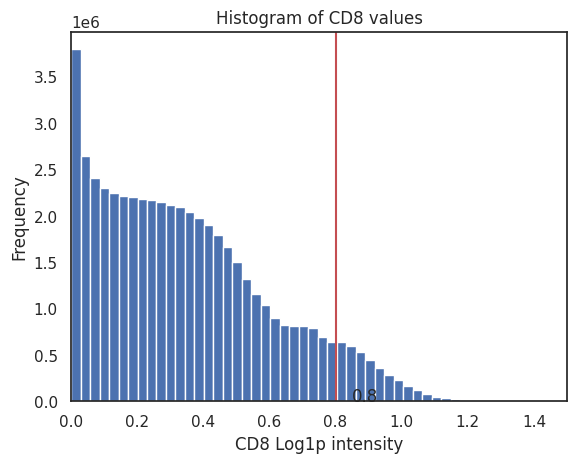

<Figure size 640x480 with 0 Axes>

In [11]:
plot_distribution(adata, 'CD8', CD8_threshold)

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

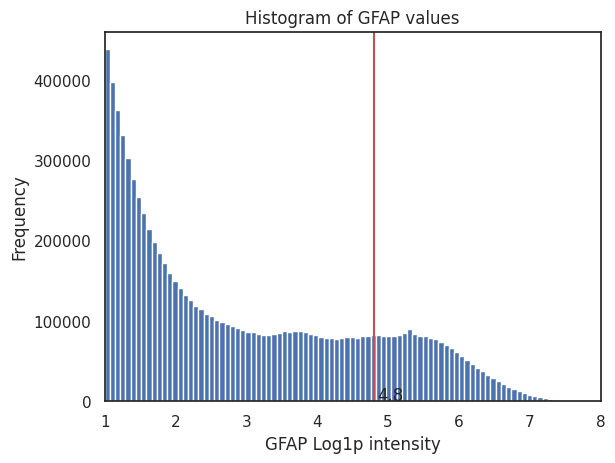

<Figure size 640x480 with 0 Axes>

In [12]:
plot_distribution(adata, 'GFAP', GFAP_threshold, xlim_max=8, show_above=1)

### Cell type calling based on thresholds

Each marker is defined with a binary column in .obs that classifies a cell as positive or negative for that marker.

Based on expression patterns, T-cells are most precise in their definition which is why they are defined first in the hierarchical phenotyping approach performed here. Next are macrophages which show a very specific signal. Cells positive for both CD8 and CD163 are assigned based on which one has a higher normalized expression (if CD8 it is still considered a T-cell, if CD163, it is reassigned to Macrophages)

While not all epithelial cells express EPCAM, non-immune cells that do should be classified as such which is why the EPCAM threshold is more lenient, as well as why Epithelial cells are next in the hierarchical phenotyping. Last, GFAP positive cells are classified as Astrocytes. GFAP has bound to the nucleus of some mitotic nuclei, likely unspecifically, mostly in the Epithelial cells which is why there isn't any extra subsetting performed.

All cells with an assigned cGAS spot are considered CIN positive, but this is mostly relevant for Epithelial and non-assigned cells due to expression patterns - e.g. cGAS overlapped with the CD8 signal which should be excluded.

In [13]:
# Create binary columns for each cell type based on the thresholds
adata.obs['CD163'] = adata.X[:,adata.uns["all_markers"].index("CD163")]>CD163_threshold
adata.obs['EPCAM'] = adata.X[:,adata.uns["all_markers"].index("EPCAM")]>EPCAM_threshold
adata.obs['GFAP'] = adata.X[:,adata.uns["all_markers"].index("GFAP")]>GFAP_threshold
adata.obs['CD8'] = adata.X[:,adata.uns["all_markers"].index("CD8")]>CD8_threshold

# Perform hierarchical phenotyping
adata.obs['phenotype'] = ['other']*adata.obs.shape[0]
adata.obs.loc[np.logical_and(adata.obs['phenotype'] == 'other', adata.obs["CD8"]), 'phenotype'] = "T-cells"
adata.obs.loc[np.logical_and(adata.obs['phenotype'] == 'other', adata.obs["CD163"]), 'phenotype'] = "Macrophages"
adata.obs.loc[np.logical_and(adata.obs['phenotype'] == 'T-cells', adata.X[:,adata.uns["all_markers"].index("CD163")] > adata.X[:,adata.uns["all_markers"].index("CD8")]),'phenotype' ]= 'Macrophages'
adata.obs.loc[np.logical_and(adata.obs['phenotype'] == 'other', adata.obs["EPCAM"]), 'phenotype'] = "Epithelium"
adata.obs.loc[np.logical_and(adata.obs['phenotype'] == 'other', adata.obs["GFAP"]), 'phenotype'] = "Astrocytes"

# Assign tissue type based on sample id
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.obs['tissue_type'] = adata.obs['tissue'].apply(lambda x: x if x in ['lung','brain'] else 'extracranial')

# Assign CIN status based on cGAS spot count
adata.obs["has_CIN"] = adata.obs["cGAS_spot_count"] > 0
adata.obs["phenotype_CIN"] = adata.obs["phenotype"].astype(str) + ["_CIN" if cin == "True" else "" for cin in adata.obs["has_CIN"].astype(str)]

### Distribution plots

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

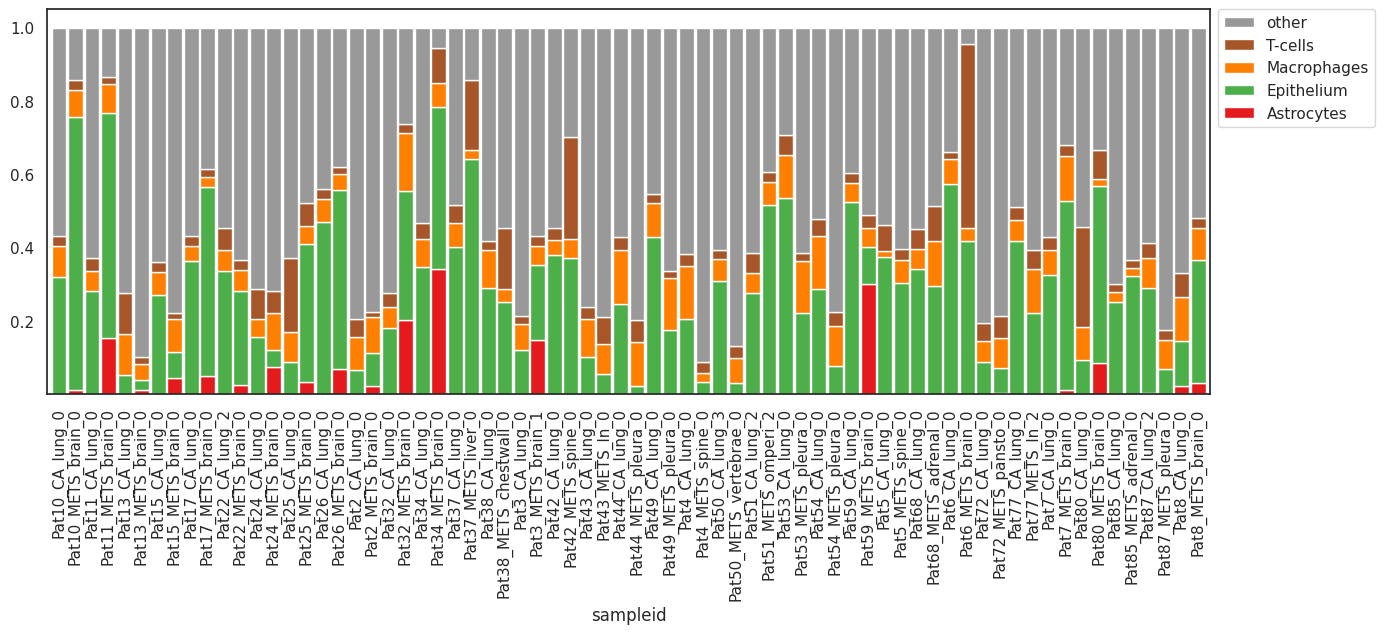

In [14]:
sm.pl.stacked_barplot (
    adata, 
    x_axis='sampleid',
    y_axis='phenotype', 
    figsize=(15, 5), 
    method='percent'
    )

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

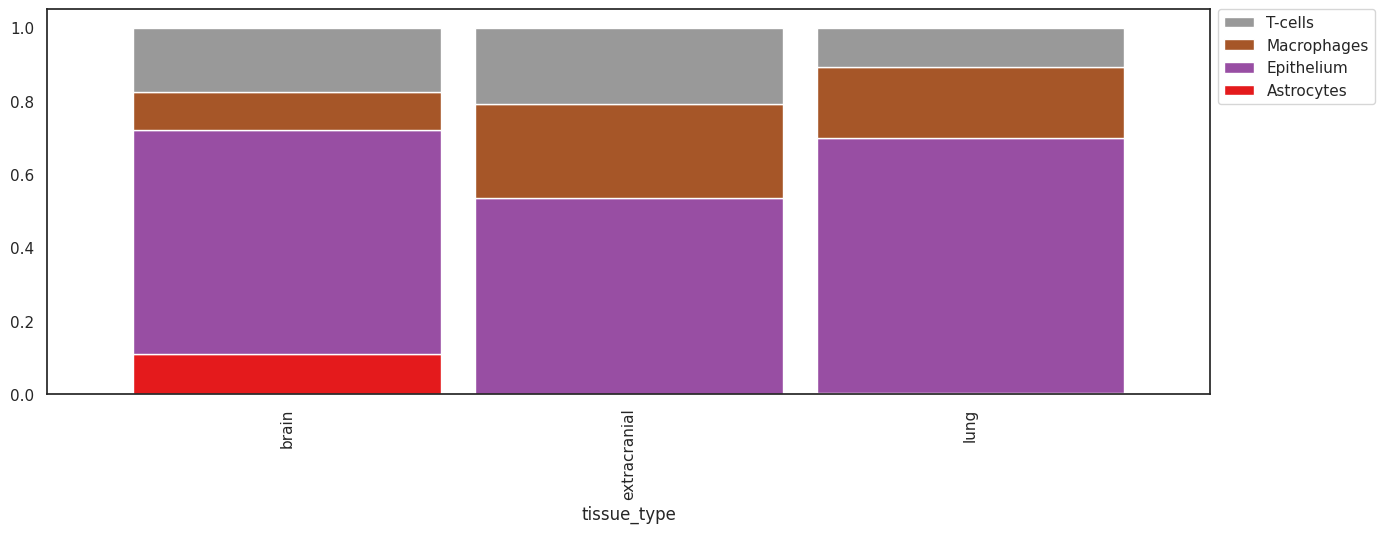

In [15]:
sm.pl.stacked_barplot (
    adata[~(adata.obs['phenotype'] == 'other'), :], 
    x_axis='tissue_type',
    y_axis='phenotype',
    figsize=(15, 5), 
    method='percent'
    )

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

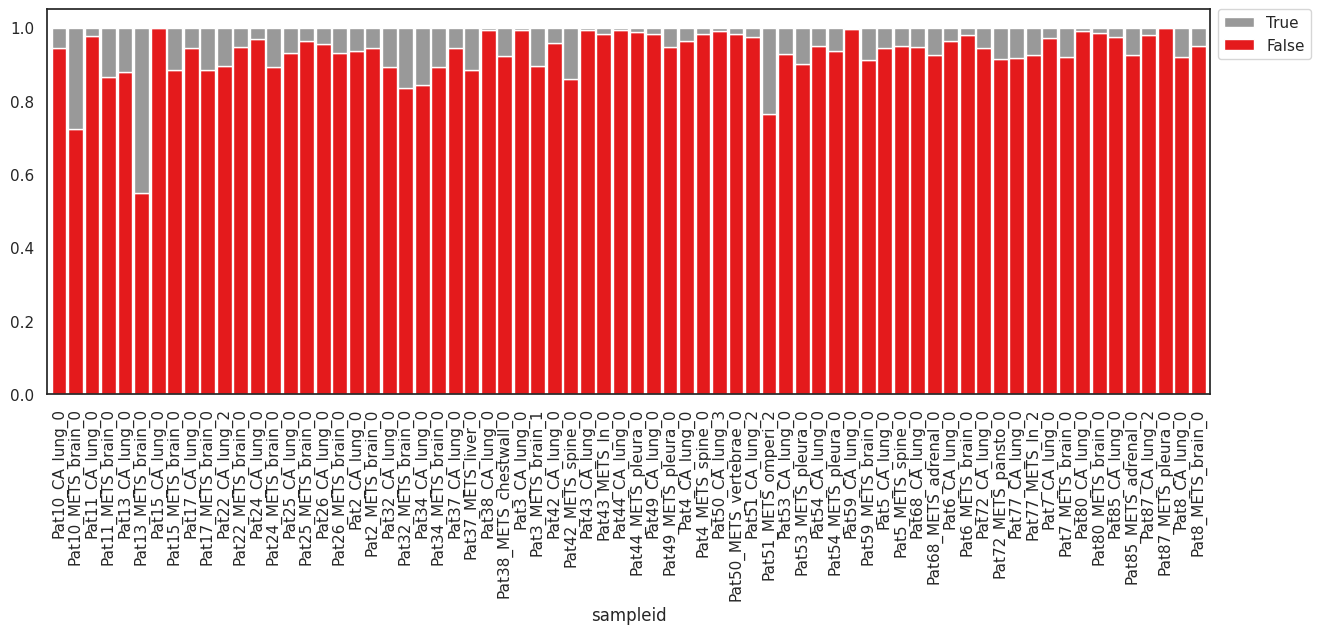

In [16]:
sm.pl.stacked_barplot (
    adata[np.logical_or(adata.obs['phenotype'] == 'Epithelium', adata.obs['phenotype'] == 'other'), :], 
    x_axis='sampleid',
    y_axis='has_CIN',
    figsize=(15, 5), 
    method='percent'
    )

### Save anndata object(s) and create summary csv for statistical analysis

In [17]:
adata.write('/gpfs/bwfor/work/ws/hd_hl269-brainmets/uint16_data/dataset/adata_CIN_20240715.h5ad')
for sample in adata.obs.sampleid.unique().astype(str):
    tmp_adata = adata[adata.obs.sampleid == sample]
    tmp_adata.write(f'/gpfs/bwfor/work/ws/hd_hl269-brainmets/uint16_data/dataset/anndata_samples/{sample}.h5ad')

In [18]:
grouped_phenotypes_per_tissue = adata.obs.groupby(['patientid', 'tissue_type','phenotype_CIN']).size().unstack(fill_value=0)
grouped_phenotypes_per_tissue['total'] = grouped_phenotypes_per_tissue.sum(axis=1)
grouped_phenotypes_per_tissue['total_epithelium'] = grouped_phenotypes_per_tissue['Epithelium'] + grouped_phenotypes_per_tissue['Epithelium_CIN']
grouped_phenotypes_per_tissue['total_macrophages'] = grouped_phenotypes_per_tissue['Macrophages'] + grouped_phenotypes_per_tissue['Macrophages_CIN']
grouped_phenotypes_per_tissue['total_tcells'] = grouped_phenotypes_per_tissue['T-cells'] + grouped_phenotypes_per_tissue['T-cells_CIN']
grouped_phenotypes_per_tissue['total_astrocytes'] = grouped_phenotypes_per_tissue['Astrocytes'] + grouped_phenotypes_per_tissue['Astrocytes_CIN']
grouped_phenotypes_per_tissue['total_other'] = grouped_phenotypes_per_tissue['other'] + grouped_phenotypes_per_tissue['other_CIN']
grouped_phenotypes_per_tissue['total_CIN'] = grouped_phenotypes_per_tissue['Epithelium_CIN'] + grouped_phenotypes_per_tissue['Macrophages_CIN'] + grouped_phenotypes_per_tissue['Macrophages_CIN'] +  grouped_phenotypes_per_tissue['T-cells_CIN'] + grouped_phenotypes_per_tissue['Astrocytes_CIN'] + grouped_phenotypes_per_tissue['other_CIN']
grouped_phenotypes_per_tissue['total_no_immune_or_astrocytes'] = grouped_phenotypes_per_tissue['total'] - grouped_phenotypes_per_tissue['Macrophages'] - grouped_phenotypes_per_tissue['T-cells'] - grouped_phenotypes_per_tissue['Astrocytes']
grouped_phenotypes_per_tissue['total_no_immune_or_astrocytes_CIN'] = grouped_phenotypes_per_tissue['total_CIN'] - grouped_phenotypes_per_tissue['Macrophages_CIN'] - grouped_phenotypes_per_tissue['T-cells_CIN'] - grouped_phenotypes_per_tissue['Astrocytes_CIN']

grouped_phenotypes_per_tissue['total_no_immune_or_astrocytes_CIN %'] = (grouped_phenotypes_per_tissue['total_no_immune_or_astrocytes_CIN'] / grouped_phenotypes_per_tissue['total_no_immune_or_astrocytes']) * 100
grouped_phenotypes_per_tissue['total_CIN %'] = (grouped_phenotypes_per_tissue['total_CIN'] / grouped_phenotypes_per_tissue['total']) * 100
grouped_phenotypes_per_tissue['Macrophages / Immune cells %'] = (grouped_phenotypes_per_tissue['total_macrophages'] / (grouped_phenotypes_per_tissue['total_macrophages'] + grouped_phenotypes_per_tissue['total_tcells'])) * 100
grouped_phenotypes_per_tissue['Epithelium_CIN %'] = (grouped_phenotypes_per_tissue['Epithelium_CIN'] / grouped_phenotypes_per_tissue['total_epithelium']) * 100
grouped_phenotypes_per_tissue['Macrophages_CIN %'] = (grouped_phenotypes_per_tissue['Macrophages_CIN'] / grouped_phenotypes_per_tissue['total_macrophages']) * 100
grouped_phenotypes_per_tissue['T-cells_CIN %'] = (grouped_phenotypes_per_tissue['T-cells_CIN'] / grouped_phenotypes_per_tissue['total_tcells']) * 100
grouped_phenotypes_per_tissue['Astrocytes_CIN %'] = (grouped_phenotypes_per_tissue['Astrocytes_CIN'] / grouped_phenotypes_per_tissue['total_astrocytes']) * 100
grouped_phenotypes_per_tissue['other_CIN %'] = (grouped_phenotypes_per_tissue['other_CIN'] / grouped_phenotypes_per_tissue['total_other']) * 100


/scratch/hd_hl269/job_4072868_m08n17/ipykernel_3006225/1737361577.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [19]:
grouped_phenotypes_per_tissue.reset_index().to_csv('/gpfs/bwfor/work/ws/hd_hl269-brainmets/uint16_data/dataset/grouped_phenotypes_per_tissue_resetindex_20240715.csv', index=False)